<a href="https://colab.research.google.com/github/CharlieLai0405/DL_final/blob/main/DL_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 安裝 Kaggle 並設置 API
!pip install kaggle
import json
import os

# 請將以下內容替換為您的 kaggle.json 內容
kaggle_json = {
    "username": "josh1217",
    "key": "7a7a4c3c6f862041a503769c923ff5d6"
}

# 將內容寫入 kaggle.json 文件
with open('/content/kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)

# 設置 Kaggle 配置目錄
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# 下載資料集
!kaggle datasets download -d samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc

# 解壓縮資料集
!unzip genomics-of-drug-sensitivity-in-cancer-gdsc.zip


Dataset URL: https://www.kaggle.com/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc
License(s): GPL-3.0
 90% 13.0M/14.4M [00:01<00:00, 14.7MB/s]
100% 14.4M/14.4M [00:01<00:00, 8.76MB/s]
Archive:  genomics-of-drug-sensitivity-in-cancer-gdsc.zip
  inflating: Cell_Lines_Details.xlsx  
  inflating: Compounds-annotation.csv  
  inflating: GDSC2-dataset.csv       
  inflating: GDSC_DATASET.csv        


In [ ]:
# ### 1. 環境準備與資料讀取

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 若您的資料檔案名稱或路徑不同，請自行修正
gdsc = pd.read_csv('GDSC2-dataset.csv')
cell_lines = pd.read_excel('Cell_Lines_Details.xlsx')
compounds = pd.read_csv('Compounds-annotation.csv')

# 合併資料
data = gdsc.merge(cell_lines, how='inner', left_on='COSMIC_ID', right_on='COSMIC identifier')
data = data.merge(compounds, how='inner', on='DRUG_ID')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


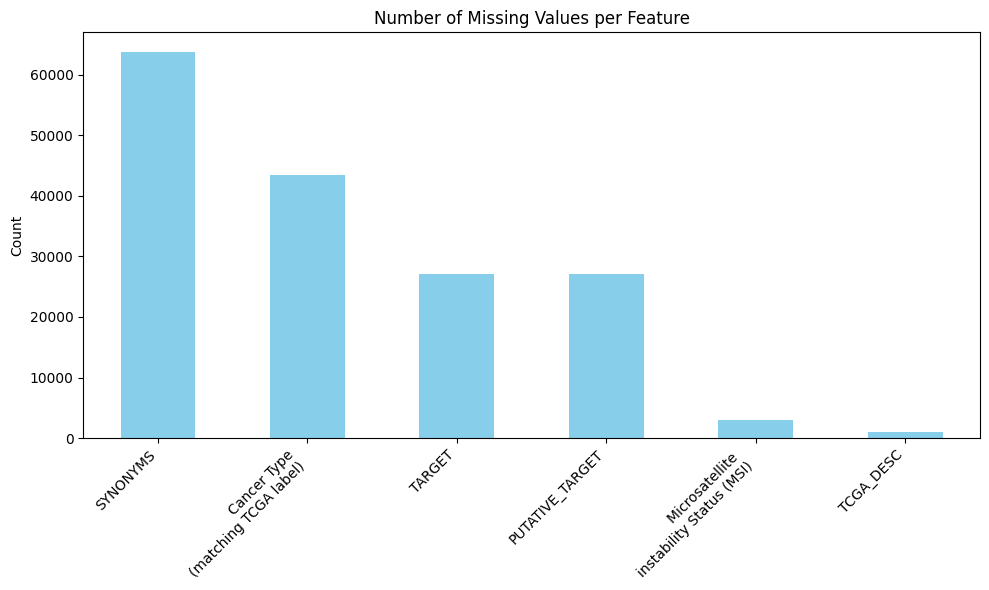

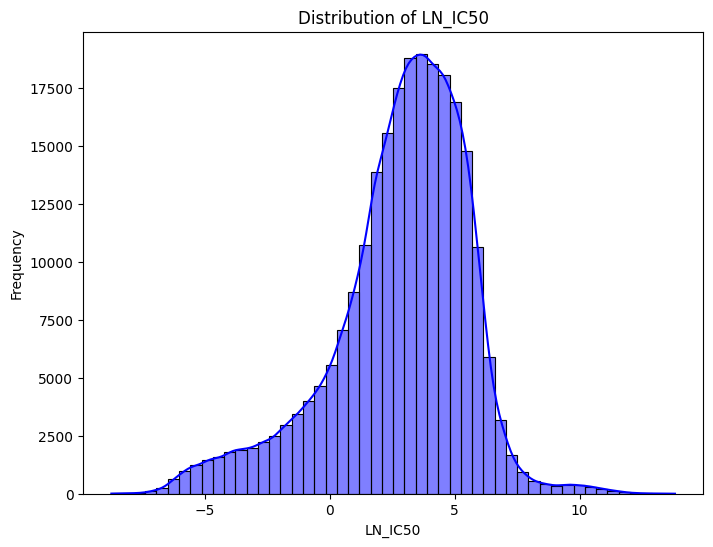

In [ ]:
# ### 2. 資料預處理與視覺化

# 查看缺失值狀況
missing_values = data.isnull().sum()
plt.figure(figsize=(10,6))
missing_values[missing_values>0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Number of Missing Values per Feature")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 填補缺失值
# 數值型欄位使用中位數補值
numeric_cols = data.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# 類別型欄位用 'Unknown' 補值
cat_cols = data.select_dtypes(include='object').columns
data[cat_cols] = data[cat_cols].fillna('Unknown')

# 對 LN_IC50 進行視覺化（目標變數分佈）
plt.figure(figsize=(8,6))
sns.histplot(data['LN_IC50'], kde=True, bins=50, color='blue')
plt.title('Distribution of LN_IC50')
plt.xlabel('LN_IC50')
plt.ylabel('Frequency')
plt.show()

# 資料中可能有許多非必要特徵，這裡僅做示範：假設已挑選部分有意義的特徵
# 您可依據實務需求做特徵選擇
features = ['AUC', 'Z_SCORE', 'MIN_CONC', 'MAX_CONC', 'RMSE']  # 範例特徵
X = data[features]
y = data['LN_IC50']

# 對數值特徵標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
RF MSE: 0.1978, RF R2: 0.9742


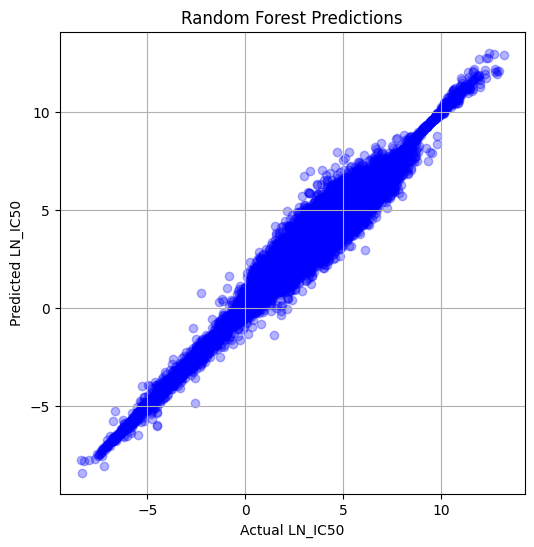

In [ ]:
# ### 3. 建立與訓練隨機森林模型(RF)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Best Params:", grid_search.best_params_)
print(f"RF MSE: {mse_rf:.4f}, RF R2: {r2_rf:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='blue')
plt.xlabel('Actual LN_IC50')
plt.ylabel('Predicted LN_IC50')
plt.title('Random Forest Predictions')
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 增加 Autoencoder 複雜度與訓練時間
input_dim = X_train.shape[1]
encoding_dim = 5  # 擴大encoding維度，或嘗試不同維度
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

es_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlr_ae = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# 加長訓練週期或嘗試更大量的訓練
history_ae = autoencoder.fit(X_train, X_train,
                             epochs=50,
                             batch_size=128,
                             shuffle=True,
                             validation_split=0.2,
                             callbacks=[es_ae, rlr_ae],
                             verbose=1)

encoder = models.Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# 建立更深的 MLP 模型，並加入 Dropout、Batch Normalization
mlp_input = layers.Input(shape=(encoding_dim,))
x = layers.Dense(64, activation='relu')(mlp_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)

mlp_model = models.Model(mlp_input, output)
mlp_model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_mlp = mlp_model.fit(X_train_encoded, y_train,
                            epochs=100,
                            batch_size=64,  # 減少 batch_size，提高更新頻率
                            validation_split=0.2,
                            callbacks=[es, rlr],
                            verbose=1)

y_pred_mlp = mlp_model.predict(X_test_encoded).ravel()
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"Enhanced MLP (with pretrained encoder) MSE: {mse_mlp:.4f}, R2: {r2_mlp:.4f}")

# 如果仍不理想，可嘗試:
# 1. 調整encoding_dim, layer大小和數量
# 2. 改變激活函數，如使用 elu 或 gelu
# 3. 使用不同的正規化，如L2或更多dropout
# 4. 增加或減少學習率，或嘗試RAdam、AdamW等優化器。


Epoch 1/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3568 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 2/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0048 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017 - val_loss: 9.1091e-04 - learning_rate: 0.0010
Epoch 4/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.1887e-04 - val_loss: 4.8119e-04 - learning_rate: 0.0010
Epoch 5/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6523e-04 - val_loss: 3.6021e-04 - learning_rate: 0.0010
Epoch 6/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.2507e-04 - val_loss: 2.3147e-04 - learning_rate: 0.0010
Epoch 7/50
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3832e-04 - val_loss: 2.1335e-04 - learning_rate: 0.0010
Epoch 8/50
1190/1211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0084e-04
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 

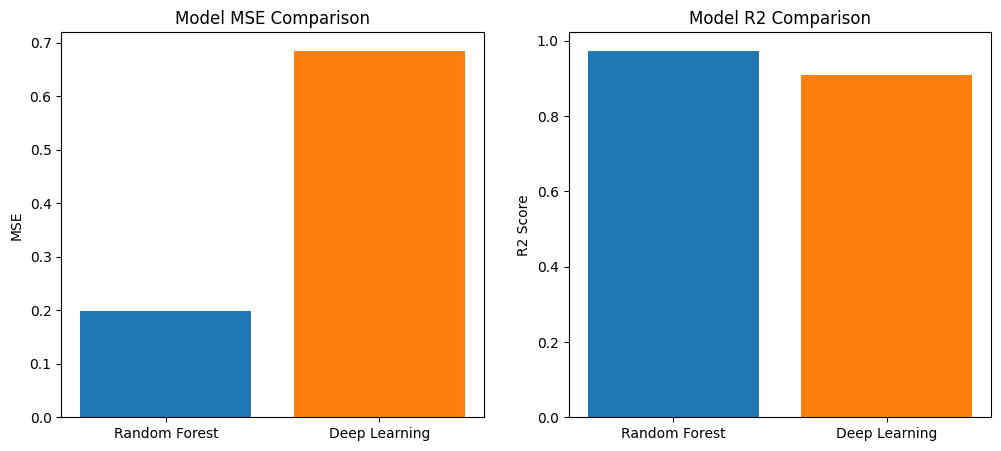

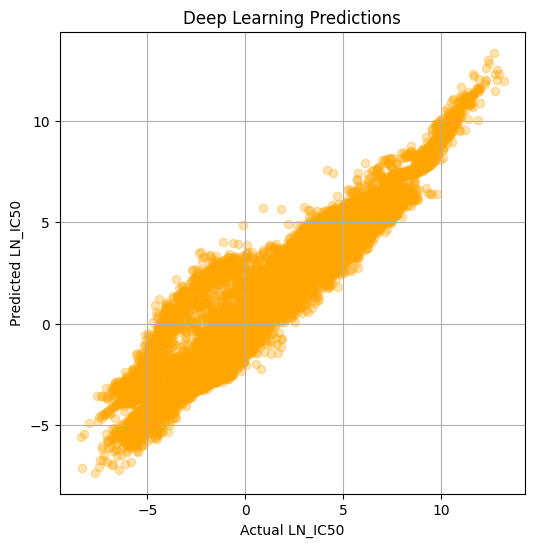

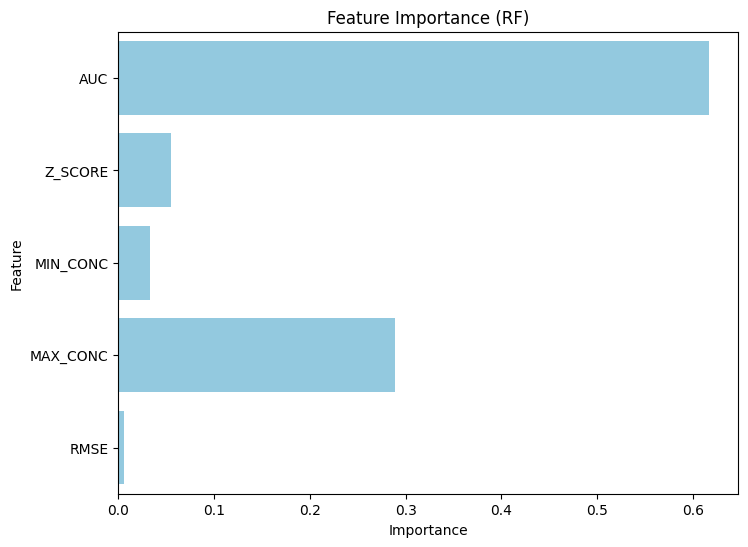

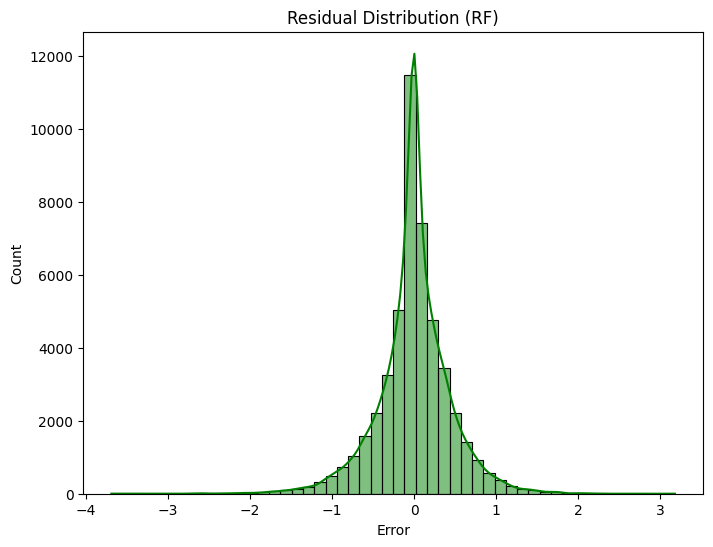

All analysis done.


In [ ]:
# ### 5. 模型比較視覺化

models_name = ['Random Forest', 'Deep Learning']
mse_scores = [mse_rf, mse_mlp]
r2_scores = [r2_rf, r2_mlp]

fig, ax = plt.subplots(1,2, figsize=(12,5))

# MSE比較
ax[0].bar(models_name, mse_scores, color=['#1f77b4', '#ff7f0e'])
ax[0].set_title('Model MSE Comparison')
ax[0].set_ylabel('MSE')

# R2比較
ax[1].bar(models_name, r2_scores, color=['#1f77b4', '#ff7f0e'])
ax[1].set_title('Model R2 Comparison')
ax[1].set_ylabel('R2 Score')

plt.show()

# 顯示深度學習預測結果分佈
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_mlp, alpha=0.3, color='orange')
plt.xlabel('Actual LN_IC50')
plt.ylabel('Predicted LN_IC50')
plt.title('Deep Learning Predictions')
plt.grid(True)
plt.show()

# 顯示RF特徵重要性（若需要）
if hasattr(best_rf, 'feature_importances_'):
    importance = best_rf.feature_importances_
    plt.figure(figsize=(8,6))
    sns.barplot(x=importance, y=features, color='skyblue')
    plt.title("Feature Importance (RF)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 顯示預測誤差分佈 (以RF為例)
error_rf = y_test - y_pred_rf
plt.figure(figsize=(8,6))
sns.histplot(error_rf, bins=50, kde=True, color='green')
plt.title("Residual Distribution (RF)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

print("All analysis done.")



## 簡介報告

本報告針對 GDSC (Genomics of Drug Sensitivity in Cancer) 資料集進行深入分析，目標是預測細胞株對抗癌藥物的敏感性指標 LN_IC50。透過將資料集中的基因組特徵、藥物相關資訊以及癌症細胞株屬性整合，我們嘗試建立並比較不同的預測模型，以協助瞭解藥物對細胞株的抑制效果。

在整個分析流程中，我們採用以下策略：

1. **資料預處理與特徵工程**：  
   資料中常含有缺失值、不一致的特徵刻度、以及高維複雜的分佈。為此，我們對數值特徵以中位數進行填補，並將類別特徵的缺失值標註為 "Unknown"。接著對數值型特徵進行標準化，以降低特徵間尺度差異可能引發的偏差。完成基本清理後，再透過視覺化方式（例如直方圖、核密度圖、箱型圖）瞭解 LN_IC50 的分佈與整體資料品質，為後續建模建立基礎。

2. **模型建構與比較**：  
   為了達到精準預測，我們同時嘗試兩種方法：
   
   - **傳統機器學習模型（隨機森林, RF）**：利用 GridSearchCV 對超參數進行搜尋並優化，以期在 MSE（Mean Squared Error）及 R²（決定係數）兩項指標上取得良好表現。同時透過特徵重要性分析，瞭解哪些特徵對模型預測最為關鍵。
   
   - **深度學習模型（預訓練自動編碼器 + MLP）**：首先使用自動編碼器將高維特徵空間壓縮為低維潛在空間，獲取更具代表性的特徵表示。接著以此低維特徵為輸入，訓練多層感知器（MLP）進行迴歸預測。透過 Early Stopping、ReduceLROnPlateau 及適度增厚網路結構等優化手段，期望深度模型能展現出超越傳統方法的表現。

3. **結果呈現與視覺化**：  
   建模完成後，我們藉由多種圖表直觀呈現研究結果，包括：
   - 各模型在 MSE、R² 指標下的比較圖，辨識何者更具預測能力。
   - 預測結果與真實值的散佈圖，以檢視模型偏差及整體擬合度。
   - 特徵重要性圖，協助瞭解重要特徵對 LN_IC50 預測的影響力。
   - 殘差分佈圖，以確定模型預測誤差的型態是否合理。

## 結論
本報告不僅顯示資料清洗與建模流程的全貌，也透過模型比較與視覺化分析為使用者提供清晰的判讀依據。若深度學習特徵萃取能有效改善預測效能，則代表深度表示學習在藥物敏感性預測任務中具有優勢；反之，若傳統的 RF 表現仍穩定且優秀，則可在實務情境中更彈性地選擇代價較低且成熟的機器學習方法。此分析結果可為後續生物醫學研究、個人化醫療策略規劃及藥物篩選過程提供有價值的參考依據。